<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/pre_act_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==2.1.0
!pip install datasets
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install diffusers
!pip install tqdm
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 70.3 MB/

In [1]:
import torch
import math
import numpy as np
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import time
import numpy
import pickle
import os

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from scipy.linalg import sqrtm
from functools import partial
from ipdb import set_trace as st

from datasets import load_dataset
from diffusers import UNet2DModel
from accelerate import Accelerator

from torch import nn
from torch import optim
from torch import autocast
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms
from torchvision.transforms import v2, InterpolationMode
from torcheval.metrics import MulticlassAccuracy

from miniai.datasets import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['image.cmap'] = 'gray_r'

set_seed(42)
mdl_path = Path('drive/MyDrive/fastai_p2/models/')

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [2]:
def collate_fn(some):
  x, y = zip(*some)
  return torch.stack(x, dim = 0), torch.stack(y, dim = 0)

class TinyImagenetDS:
  def __init__(self, im_paths, labels):
    fc.store_attr()
    self.tfm = transforms.ToTensor()

  def __getitem__(self, idx):
    return transforms.ToTensor()(Image.open(self.im_paths[idx])), torch.tensor(self.labels[idx])

  def __len__(self): return len(self.im_paths)

class AveragePool(nn.Module):
  def forward(self, x): return x.mean((-1, -2))

def conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)]
  if act: layers.append(act())
  if norm: layers.append(norm(nf) if norm.__name__ in ("BatchNorm2d", "BatchNorm1d", "BatchNorm3d") else norm()) # else its a batch norm.
  return nn.Sequential(*layers)

class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x): return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'ResBlock'

class ResBlockV2(ResBlock):

  def forward(self, x): return self.conserve(x) + self.act_fn(self.play(x))

  def __name__(self):
    return 'ResBlockV2'

class ResBlockDV2(ResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu, p = 0.1, dropout_func = nn.Dropout2d(0.2)):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = dropout_func

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'


class ResBlockDV3(ResBlockV2):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu, p = 0.1, dropout_func = nn.Dropout2d(0.2)):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = dropout_func

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

class UnetModel(UNet2DModel):
  def forward(self, x): return super().forward(*x).sample

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

class LRScheduler:
  def __init__(self):
    self.batch_count = 0

  def step(self):
    raise NotImplementedError()

class DropoutScheduler(LRScheduler):
  def __init__(self, epochs = 10, min = 0.2, max = 0.5):
    self.drops = iter(torch.linspace(min, max, steps = epochs))

  def step(self):
    return next(self.drops)

class DropoutCB(Callback):
  def __init__(self, drop_sched): fc.store_attr()
  def before_epoch(self, learn):
    if not learn.training: return
    p = self.drop_sched.step()
    for block in learn.model:
      if isinstance(block, ResBlockDV2): block.drop.p = p
      if isinstance(block, (nn.Dropout, nn.Dropout2d)): block.p = p

In [3]:
class TinyImagenetDS:
  def __init__(self, im_paths, labels):
    fc.store_attr()
    self.tfm = transforms.ToTensor()

  def __getitem__(self, idx):
    return transforms.ToTensor()(Image.open(self.im_paths[idx])), torch.tensor(self.labels[idx])

  def __len__(self): return len(self.im_paths)

def pre_conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = []
  if act: layers.append(act())
  if norm: layers.append(norm(ni) if norm.__name__ in ("BatchNorm2d", "BatchNorm1d", "BatchNorm3d") else norm()) # else its a layer norm.
  layers.append(nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias))
  return nn.Sequential(*layers)

class PreActResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        pre_conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        pre_conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = pre_conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x):
    return self.conserve(x) + self.play(x)

  def __name__(self):
    return 'PreResBlock'

class PreActResBlockD(PreActResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu, p = 0.1, dropout_func = nn.Dropout2d(0.2)):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = dropout_func

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

class AugmentNormCB(Callback):
  order = 20
  def __init__(self, transforms = None):
    fc.store_attr()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.mean = torch.tensor([0.4810, 0.4482, 0.3968], device = device)
    self.std = torch.tensor([0.2760, 0.2683, 0.2813], device = device)
    if not self.transforms:
      self.transforms = v2.Compose([
          v2.RandomHorizontalFlip(p = 0.5),
          v2.RandomPerspective(distortion_scale=0.2, p=0.8),
          RandErase(0.2)
      ])

  def before_batch(self, learn):
    if learn.training: learn.batch = (self.transforms(learn.batch[0]), learn.batch[1])
    x = learn.batch[0]
    x = (x - self.mean[None, :, None, None])/(self.std[None, :, None, None])
    learn.batch = (x, learn.batch[1])

class AugmentNormCBV2(AugmentNormCB):
  def __init__(self, total_epochs, threshold = 0.1, initial_transforms = [], addtional_transforms = []):
    fc.store_attr()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.mean = torch.tensor([0.47565, 0.40303, 0.31555], device = device)
    self.std = torch.tensor([0.28858, 0.24402, 0.26615], device = device)
    self.transforms = v2.Compose(self.initial_transforms)
    self.task_done = False

  def before_epoch(self, learn):
    if (learn.epoch >= self.total_epochs*self.threshold) and self.task_done == False:
      self.transforms = v2.Compose(self.initial_transforms + self.addtional_transforms)
      self.task_done = True

def init_weights(m, leaky = 0.):
  if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Conv3d, nn.Linear)): nn.init.kaiming_normal_(m.weight, a = leaky)


# function to build model with nfs and nls
def blocks(nls, ni, nf, block, act = GeneralRelu):
  # return [PreActResBlock(ni, nf, act = act)] + [PreActResBlock(nf, nf, stride = 1, act = act) if i < nls - 1 else block(nf, nf, stride = 1, act = act) for i in range(nls - 1)]
  return [PreActResBlock(ni, nf, act = act)] + [PreActResBlock(nf, nf, stride = 1, act = act) for i in range(nls - 1)]

def get_model(block = PreActResBlockD, act = GeneralRelu, nls = [1, 3, 5, 3, 1], nfs = [32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True, p = 0.2):

  pnf, layers = 3, []
  for nl, nf in zip(nls, nfs):
    layers += blocks(nl, pnf, nf, block, act = act)
    pnf = nf

  return nn.Sequential(*layers, nn.BatchNorm2d(nfs[-1]), act(), AveragePool(), nn.Dropout(p), nn.Linear(nf, nc, bias = False), nn.BatchNorm1d(nc))

In [4]:
def get_model_2(block = PreActResBlock, act = GeneralRelu, nls = [1, 3, 5, 3, 1], nfs = [32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True, p = 0.2):

  pnf, layers = nfs[0], [PreActResBlock(3, nfs[0], stride = 1, ks = 7, act = act)]
  for nl, nf in zip(nls[1:], nfs[1:]):
    layers += blocks(nl, pnf, nf, block, act = act)
    pnf = nf

  return nn.Sequential(*layers, nn.BatchNorm2d(nfs[-1]), act(), AveragePool(), nn.Dropout(p), nn.Linear(nf, nc, bias = False), nn.BatchNorm1d(nc))

In [ ]:
!wget 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
!unzip tiny-imagenet-200.zip

# Data Prep

In [7]:
tfm = transforms.ToTensor()

def _verify_im_path(im_path):
  im = Image.open(im_path)
  im_t = tfm(im)
  del im
  if im_t.shape[0] == 1: return False
  return True

def verify_ims(im_paths):
  verified_paths = []
  for i in im_paths:
    if _verify_im_path(i): verified_paths.append(i)
  return verified_paths

def get_train_d(path, limit = None):
  im_paths, classes = [], []
  for i in tqdm(path.ls()):
    cla = i.name
    ps = (i/'images').ls()
    if limit != None: ps = ps[:limit]
    ims = verify_ims(ps)
    im_paths += ims
    classes += [cla]*len(ims)
  return im_paths, classes

def get_valid_d(path):
  paths, classes = [], []
  with open(path/"val_annotations.txt", 'r') as f:
    for i in tqdm(f.read().splitlines()):
      im_path = path/'images'/i.split()[0]
      if _verify_im_path(im_path):
        paths.append(im_path)
        classes.append(i.split()[1])
  return paths, classes

In [8]:
train_im_paths, train_labels = get_train_d(Path('tiny-imagenet-200/train'), limit = None)
valid_paths, valid_classes = get_valid_d(Path('tiny-imagenet-200/val'))

100%|██████████| 10000/10000 [00:05<00:00, 1836.97it/s]


In [9]:
class_dict = {v: i for i, v in enumerate(set(train_labels))}
new_train_labels = tuple(map(lambda x: class_dict[x], train_labels))
new_valid_labels = tuple(map(lambda x: class_dict[x], valid_classes))

In [5]:
class TinyImagenetDS:
  def __init__(self, im_paths, labels):
    fc.store_attr()
    self.tfm = transforms.ToTensor()

  def __getitem__(self, idx):
    return transforms.ToTensor()(Image.open(self.im_paths[idx])), torch.tensor(self.labels[idx])

  def __len__(self): return len(self.im_paths)

In [11]:
train_ds = TinyImagenetDS(train_im_paths, new_train_labels)
valid_ds = TinyImagenetDS(valid_paths, new_valid_labels)
len(train_ds), len(valid_ds)

(98179, 9832)

In [12]:
with open('/content/drive/MyDrive/fastai_p2/tiny_img_net/dls/train_ds.pkl', 'wb') as f:
  pickle.dump(train_ds, f)

with open('/content/drive/MyDrive/fastai_p2/tiny_img_net/dls/valid_ds.pkl', 'wb') as f:
  pickle.dump(valid_ds, f)

In [8]:
def collate_fn(some):
  x, y = zip(*some)
  return torch.stack(x, dim = 0), torch.stack(y, dim = 0)

In [14]:
train_dl, valid_dl = DataLoader(train_ds, 512, True, collate_fn = collate_fn, num_workers = 2), DataLoader(valid_ds, 512, True, collate_fn = collate_fn, num_workers = 2)

# Experiments with Modeling.

In [10]:
with open('/content/drive/MyDrive/fastai_p2/tiny_img_net/dls/train_ds.pkl', 'rb') as f: train_ds = pickle.load(f)
with open('/content/drive/MyDrive/fastai_p2/tiny_img_net/dls/valid_ds.pkl', 'rb') as f: valid_ds = pickle.load(f)

train_dl, valid_dl = DataLoader(train_ds, 512, True, collate_fn = collate_fn, num_workers = 2), DataLoader(valid_ds, 512, True, collate_fn = collate_fn, num_workers = 2)

In [11]:
train_dl, valid_dl = DataLoader(train_ds, 512, True, collate_fn = collate_fn, num_workers = 2), DataLoader(valid_ds, 512, True, collate_fn = collate_fn, num_workers = 2)

In [10]:
x, y = next(iter(train_dl))

In [11]:
x.shape, y.shape

(torch.Size([512, 3, 64, 64]), torch.Size([512]))

In [ ]:
# Check in lr scheduler after what epoch learning rate reduces - 0.3*total_steps
# Experiment with adding higher transforms after epoch 0.1*total_steps and 0.3*total_steps.
# Check the models activation functions - get it general relu with right amount of leak - Build the model - Refactor the code
    # Blocks Required:- Pre Act Resblocks, Dropout versions of pre act resblocks, function to build model with nfs and nls - done
# Make the network more deeper and more layers at each level - done
# Re factor the code properly. - done

# Just complete Aug Norm CB v2

In [12]:
# function to build model with nfs and nls
def blocks(nls, ni, nf, block, act = GeneralRelu):
  # return [PreActResBlock(ni, nf, act = act)] + [PreActResBlock(nf, nf, stride = 1, act = act) if i < nls - 1 else block(nf, nf, stride = 1, act = act) for i in range(nls - 1)]
  return [PreActResBlock(ni, nf, act = act)] + [PreActResBlock(nf, nf, stride = 1, act = act) for i in range(nls - 1)]

def get_model(block = PreActResBlockD, act = GeneralRelu, nls = [1, 3, 5, 3, 1], nfs = [32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True, p = 0.2):

  pnf, layers = 3, []
  for nl, nf in zip(nls, nfs):
    layers += blocks(nl, pnf, nf, block, act = act)
    pnf = nf

  return nn.Sequential(*layers, nn.BatchNorm2d(nfs[-1]), act(), AveragePool(), nn.Dropout(p), nn.Linear(nf, nc, bias = False), nn.BatchNorm1d(nc))

In [17]:
act_gr = partial(GeneralRelu, leak = 0.1)
iw = partial(init_weights, leaky = 0.1)

In [18]:
dls = DataLoaders(train_dl, valid_dl)
lr_max, epochs = 4e-03, 75
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(accuracy = MulticlassAccuracy()),
          ProgressCB(plot = True),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          AugmentNormCBV2(total_epochs = epochs, threshold = 0.1,
                            initial_transforms = [v2.RandomHorizontalFlip(p = 0.5),
                                                  v2.Pad(4),
                                                  v2.RandomCrop(size=(64, 64)),
                                                  v2.TrivialAugmentWide(interpolation = InterpolationMode.BILINEAR),
                                                  RandErase(max_num = 4)] ,
                            addtional_transforms=[]#[RandErase(max_num = 4)]
                          )
      ]
model = get_model(act = act_gr, nls = [1, 5, 8, 5, 2, 1], nfs = [64, 128, 256, 512, 1024, 2048], nc = 200, norm = nn.BatchNorm2d, bias = True, p = 0.2).apply(iw)
learner = AccLearner(model, dls, loss_func = nn.CrossEntropyLoss(), lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)

accuracy,loss,epoch,train
0.067,4.699,0,train
0.134,4.199,1,train
0.167,3.976,2,train
0.198,3.773,3,train
0.225,3.609,4,train
0.242,3.509,5,train
0.282,3.275,6,train
0.297,3.185,7,train
0.315,3.067,8,train
0.334,2.965,9,train


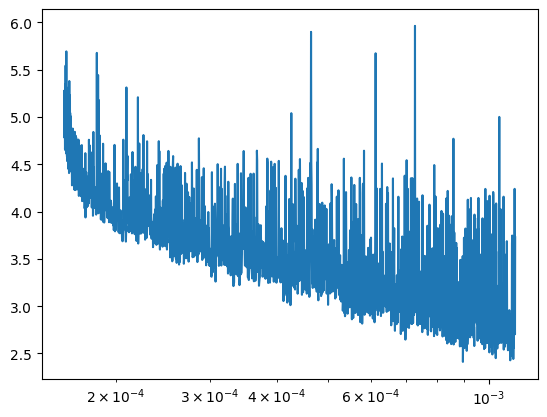

In [29]:
learner.lr_find()

In [ ]:
learner.fit(epochs)

In [ ]:
torch.save(learner.model, mdl_path/'pre_act_75_epoch_reengineered.pkl')

# Lighter Model

In [5]:
act_gr = partial(GeneralRelu, leak = 0.1)
iw = partial(init_weights, leaky = 0.1)

accuracy,loss,epoch,train
0.016,5.371,0,train
0.038,5.070,0,eval
0.032,5.064,1,train
0.055,4.828,1,eval
0.048,4.872,2,train
0.075,4.630,2,eval
0.061,4.749,3,train
0.088,4.485,3,eval
0.079,4.615,4,train
0.112,4.332,4,eval


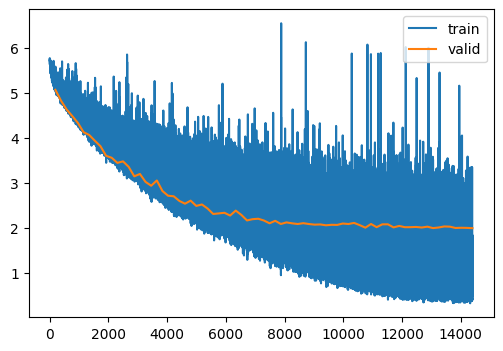

In [17]:
dls = DataLoaders(train_dl, valid_dl)
lr_max, epochs = 5e-04, 75
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(accuracy = MulticlassAccuracy()),
          ProgressCB(plot = True),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          AugmentNormCBV2(total_epochs = epochs, threshold = 0.1,
                            initial_transforms = [v2.RandomHorizontalFlip(p = 0.5),
                                                  v2.Pad(4),
                                                  v2.RandomCrop(size=(64, 64)),
                                                  v2.TrivialAugmentWide(interpolation = InterpolationMode.BILINEAR),
                                                  RandErase(max_num = 4)] ,
                            addtional_transforms=[]#[RandErase(max_num = 4)]
                          )
      ]

model = get_model(act = act_gr, nls = [1, 3, 5, 3, 1], nfs = [64, 128, 256, 512, 1024], nc = 200, norm = nn.BatchNorm2d, bias = True, p = 0.2).apply(iw)
learner = AccLearner(model, dls, loss_func = nn.CrossEntropyLoss(), lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

In [ ]:
learner.fit(epochs)

In [ ]:
from google.colab import runtime
runtime.unassign()

In [6]:
with open('/content/drive/MyDrive/fastai_p2/tiny_img_net/dls/train_ds.pkl', 'rb') as f: train_ds = pickle.load(f)
with open('/content/drive/MyDrive/fastai_p2/tiny_img_net/dls/valid_ds.pkl', 'rb') as f: valid_ds = pickle.load(f)

train_dl, valid_dl = DataLoader(train_ds, 256, True, collate_fn = collate_fn, num_workers = 2), DataLoader(valid_ds, 256, True, collate_fn = collate_fn, num_workers = 2)

accuracy,loss,epoch,train
0.060,4.824,0,train
0.106,4.365,0,eval
0.115,4.353,1,train
0.144,4.135,1,eval
0.156,4.069,2,train
0.199,3.741,2,eval
0.185,3.899,3,train
0.230,3.576,3,eval
0.212,3.728,4,train
0.260,3.373,4,eval


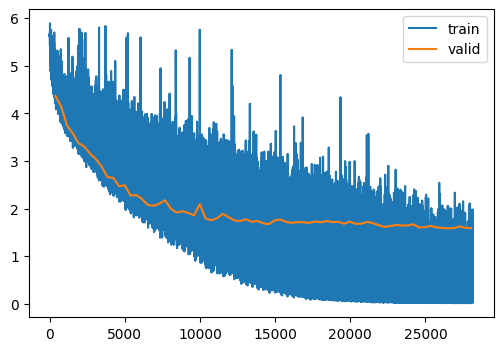

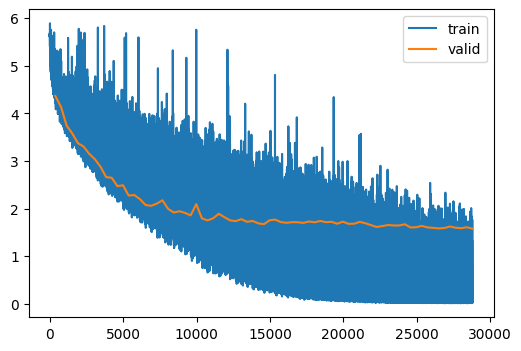

accuracy,loss,epoch,train
0.060,4.824,0,train
0.106,4.365,0,eval
0.115,4.353,1,train
0.144,4.135,1,eval
0.156,4.069,2,train
0.199,3.741,2,eval
0.185,3.899,3,train
0.230,3.576,3,eval
0.212,3.728,4,train
0.260,3.373,4,eval


In [7]:
dls = DataLoaders(train_dl, valid_dl)
lr_max, epochs = 5e-04, 75
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(accuracy = MulticlassAccuracy()),
          ProgressCB(plot = True),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          AugmentNormCBV2(total_epochs = epochs, threshold = 0.1,
                            initial_transforms = [v2.RandomHorizontalFlip(p = 0.5),
                                                  v2.Pad(4),
                                                  v2.RandomCrop(size=(64, 64)),
                                                  v2.TrivialAugmentWide(interpolation = InterpolationMode.BILINEAR),
                                                  RandErase(max_num = 4)],
                            addtional_transforms = []#[RandErase(max_num = 4)]
                          )
      ]

model = get_model_2(act = act_gr, nls = [1, 2, 3, 5, 3, 1], nfs = [64, 128, 256, 512, 1024, 2048], nc = 200, norm = nn.BatchNorm2d, bias = True, p = 0.2).apply(iw)
learner = AccLearner(model, dls, loss_func = nn.CrossEntropyLoss(), lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

In [ ]:
from google.colab import runtime
runtime.unassign()